<h1>Network Analysis for Anti-Money Laundering with Python</h1>

Tutorial at Medium: https://medium.com/@jasonclwu/network-analysis-for-anti-money-laundering-with-python-ad981792a947?source=friends_link&sk=4e9b00afed35cce27d22f3cf345998a9

Notebook at Github: https://github.com/jasonclwu/202209_AML_Network_Analysis


<h2>Importing Libraries</h2>

In [1]:
import pandas as pd
import networkx as nx
from pyvis import network as net
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.float_format = '{:,.0f}'.format

<h2>Dataset</h2>

In [2]:
# https://www.kaggle.com/datasets/anshankul/ibm-amlsim-example-dataset

from zipfile import ZipFile
with ZipFile('data.zip','r') as zip:
    zip.extractall(path='data')

<h2>Play around with networkx and pyvis using small dataset</h2>

In [3]:
txn_small = pd.read_csv('data/transactions_sample.csv', usecols=['SENDER_ACCOUNT_ID','RECEIVER_ACCOUNT_ID','TX_AMOUNT'], dtype='object')
txn_small['TX_AMOUNT'] = txn_small['TX_AMOUNT'].astype(float)
txn_small

,SENDER_ACCOUNT_ID,RECEIVER_ACCOUNT_ID,TX_AMOUNT
0,7366,8662,65
1,9245,7121,"1,043"
2,6427,9245,501
3,7515,8255,587
4,7515,8255,587
...,...,...,...
1845,6427,9245,501
1846,7515,8255,587
1847,7515,8255,587
1848,6427,9245,501


<h3>Obtain Transaction Summary for Each Node Pair</h3>

In [4]:
edge_small = txn_small.groupby(['SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID'],as_index=False).agg({'TX_AMOUNT':['count','sum']})
edge_small.columns = ['source','target','agg_txn_count','agg_txn_amt']
edge_small

,source,target,agg_txn_count,agg_txn_amt
0,6427,8264,1,4
1,6427,9245,177,"88,751"
2,7366,1332,2,"2,357,413"
3,7366,5463,2,"1,527,734"
4,7366,5717,2,"344,658"
...,...,...,...,...
103,9628,9917,20,"2,230"
104,9628,9961,20,"2,230"
105,9628,9973,20,"2,230"
106,9628,9974,20,"2,230"


<h2>Import Transactions to Networkx</h2>

In [5]:
G = nx.from_pandas_edgelist(edge_small, source='source', target='target')

In [6]:
# Show the first 5 node of G
list(G.nodes)[0:5]


['6427', '8264', '9245', '7366', '1332']

In [7]:
# Show the first 5 edge of G
list(G.edges)[0:5]

[('6427', '8264'),
 ('6427', '9245'),
 ('9245', '9056'),
 ('9245', '1651'),
 ('9245', '2483')]

In [8]:
# Show the first 5 node of G with all attributes
list(G.nodes(data=True))[0:5]

[('6427', {}), ('8264', {}), ('9245', {}), ('7366', {}), ('1332', {})]

In [9]:
# Show the first 5 edge of G with all attributes
list(G.edges(data=True))[0:5]

[('6427', '8264', {}),
 ('6427', '9245', {}),
 ('9245', '9056', {}),
 ('9245', '1651', {}),
 ('9245', '2483', {})]

<h3>Various network layout</h3>

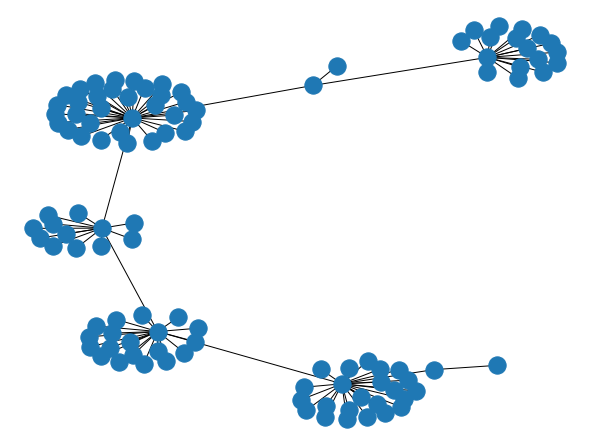

In [10]:
# Networkx Default Layout
plt.figure(figsize=(8,6))
nx.draw(G)
plt.show()

In [11]:
# Pyvis Default Layout
nt = net.Network(width='100%', height='100%', directed=True)
nt.from_nx(G)
nt.show('01_pyvis_default.html')

<h3>Create function for drawing network graph</h3>

In [12]:
def show_graph(graph, filename):
    nt = net.Network(width='100%', height='100%', directed=True)
    nt.from_nx(graph)
    nt.show(filename)

<h2>Setting Node Attributes</h2>

<h3>Set the node size according to the degree (number of connections) of node</h3>

In [13]:
list(G.degree)[0:5]

[('6427', 2), ('8264', 1), ('9245', 24), ('7366', 13), ('1332', 1)]

In [14]:
degree_dict_G = dict(G.degree)
nx.set_node_attributes(G, degree_dict_G, 'value')

In [15]:
list(G.nodes(data=True))[0:5]

[('6427', {'size': 10, 'value': 2}),
 ('8264', {'size': 10, 'value': 1}),
 ('9245', {'size': 10, 'value': 24}),
 ('7366', {'size': 10, 'value': 13}),
 ('1332', {'size': 10, 'value': 1})]

In [16]:
show_graph(G, '02_node_size.html')

<h3>Retrieve ID for each node and display in graph (hover on node)</h3>

In [17]:
title_dict_G = {}
for node in list(G.nodes):
    title_dict_G[node] = f'id: {node}'
nx.set_node_attributes(G, title_dict_G, 'title')
show_graph(G, '03_node_title_1.html')

<h3>Retrieve neighbors for each node</h3>

In [18]:
list(G.neighbors('8682'))[0:5]

['2612', '4501', '5071', '5928', '6124']

In [19]:
neighbor_dict_G = {}
for node in list(G.nodes):
    neighbor_dict_G[node] = ','.join(G.neighbors(node))

<h3>Display ID, Degree and Neighbors in Graph (Hover on Node)</h3>

In [20]:
title_dict_G = {}
for node in list(G.nodes):
    title_dict_G[node] = f'id: {node}\ndegree: {degree_dict_G[node]}\nneighbor: {neighbor_dict_G[node]}'
nx.set_node_attributes(G, title_dict_G, 'title')

show_graph(G, '04_node_title_2.html')

<h2>Setting Edge Attributes</h2>

In [21]:
edge_small['value'] = edge_small['agg_txn_amt']
edge_small['title'] = edge_small.apply(lambda df: f'from: {df.source}\nto: {df.target}\nagg_count: {df.agg_txn_count:,.0f}\nagg_amount: {df.agg_txn_amt:,.0f}', axis=1)
edge_small.head()

,source,target,agg_txn_count,agg_txn_amt,value,title
0,6427,8264,1,4,4,from: 6427\nto: 8264\nagg_count: 1\nagg_amount: 4
1,6427,9245,177,"88,751","88,751",from: 6427\nto: 9245\nagg_count: 177\nagg_amou...
2,7366,1332,2,"2,357,413","2,357,413",from: 7366\nto: 1332\nagg_count: 2\nagg_amount...
3,7366,5463,2,"1,527,734","1,527,734",from: 7366\nto: 5463\nagg_count: 2\nagg_amount...
4,7366,5717,2,"344,658","344,658",from: 7366\nto: 5717\nagg_count: 2\nagg_amount...


<h3>Setting edge size and information to display on hover</h3>

In [22]:
edge_dict_G = {}
for index, row in edge_small.iterrows():
    edge_dict_G[tuple([row['source'], row['target']])] = {'value':row['value'], 'title':row['title']}
nx.set_edge_attributes(G, edge_dict_G)

show_graph(G, '05_edge_title_and_value.html')

<h2>Community Detection with Large Dataset</h2>

In [23]:
txn_full = pd.read_csv('data/transactions.csv', usecols=['SENDER_ACCOUNT_ID','RECEIVER_ACCOUNT_ID','TX_AMOUNT'], dtype='object')
txn_full['TX_AMOUNT'] = txn_full['TX_AMOUNT'].astype(float)

edge_large = txn_full.groupby(['SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID'],as_index=False).agg({'TX_AMOUNT':['count','sum']}).sample(2000, random_state=721)
edge_large.columns = ['source','target','agg_edge_large_count','agg_edge_large_amt']
edge_large['value'] = edge_large['agg_edge_large_amt']
edge_large['title'] = edge_large.apply(lambda df: f'from: {df.source}\nto: {df.target}\nagg_count: {df.agg_edge_large_count:,.0f}\nagg_amount: {df.agg_edge_large_amt:,.0f}', axis=1)

edge_large

,source,target,agg_edge_large_count,agg_edge_large_amt,value,title
63958,9703,6059,20,"2,506","2,506",from: 9703\nto: 6059\nagg_count: 20\nagg_amoun...
38025,7369,9795,2,"1,338,379","1,338,379",from: 7369\nto: 9795\nagg_count: 2\nagg_amount...
64700,9722,9962,20,"2,973","2,973",from: 9722\nto: 9962\nagg_count: 20\nagg_amoun...
41653,7881,9751,20,"5,923","5,923",from: 7881\nto: 9751\nagg_count: 20\nagg_amoun...
23451,5376,4205,2,"1,755,996","1,755,996",from: 5376\nto: 4205\nagg_count: 2\nagg_amount...
...,...,...,...,...,...,...
61987,9647,9206,20,"3,453","3,453",from: 9647\nto: 9206\nagg_count: 20\nagg_amoun...
5068,2132,8921,23,701,701,from: 2132\nto: 8921\nagg_count: 23\nagg_amoun...
21665,5185,5233,21,448,448,from: 5185\nto: 5233\nagg_count: 21\nagg_amoun...
68701,998,275,15,"5,846","5,846",from: 998\nto: 275\nagg_count: 15\nagg_amount:...


In [24]:
H = nx.from_pandas_edgelist(edge_large, source='source', target='target', edge_attr=['title','value'])

#Note that we add the argument "edge_attr" in "from_pandas_edgelist" so that we don't have to add edge attribute seperately.

In [25]:
list(H.edges(data=True))[0:2]

[('9703',
  '6059',
  {'title': 'from: 9703\nto: 6059\nagg_count: 20\nagg_amount: 2,506',
   'value': 2505.7999999999997}),
 ('6059',
  '7182',
  {'title': 'from: 6059\nto: 7182\nagg_count: 22\nagg_amount: 228',
   'value': 228.14000000000004})]

In [26]:
nt = net.Network(width='100%', height='100%', directed=False)
nt.toggle_physics(False)
nt.from_nx(H)
nt.show('06_H_full.html')

<h3>Identify mutually exclusive communities</h3>

In [27]:
list(nx.connected_components(H))[0:5]

[{'4333', '6059', '7182', '9703'},
 {'4297', '5573', '7266', '7369', '9795'},
 {'5788', '8914', '9722', '9962'},
 {'6333', '7881', '7911', '9751', '9797'},
 {'4205', '474', '5366', '5376', '8708', '9789'}]

In [28]:
len(list(nx.connected_components(H)))

1041

<h3>Assign community to each node</h3>

In [29]:
group_dict_H = {}

for group, nodes in enumerate(sorted(list(nx.connected_components(H)), key=len, reverse=True), start=1):
    for node in nodes:
        group_dict_H[node] = group

In [30]:
## Alternative algorithm for community detection
## https://python-louvain.readthedocs.io/en/latest/api.html
## NOT RECOMMENDED FOR MONEY LAUNDERING DETECTION

# import community.community_louvain as community_louvain
# group_dict_H = community_louvain.best_partition(G, random_state=721)

## Other algorithms: https://networkx.org/documentation/stable/reference/algorithms/community.html

In [31]:
groups = pd.DataFrame({'source':group_dict_H.keys(), 'group':group_dict_H.values()}).sort_values(by=['group','source'])
groups

,source,group
47,1087,1
13,1609,1
58,1890,1
44,1905,1
62,2369,1
...,...,...
3035,5233,1039
3037,275,1040
3036,998,1040
3038,7693,1041


In [32]:
group_summary = groups.groupby('group', as_index=False).agg({'source':'count'}).rename(columns={'source':'num_of_nodes'})
group_summary

,group,num_of_nodes
0,1,64
1,2,35
2,3,27
3,4,24
4,5,21
...,...,...
1036,1037,2
1037,1038,2
1038,1039,2
1039,1040,2


<h3>Display ID, group, degree and neighbors in graph (hover on node)</h3>

In [33]:
nx.set_node_attributes(H, group_dict_H, 'group')

degree_dict_H = dict(H.degree)
nx.set_node_attributes(H, degree_dict_H, 'value')

neighbor_dict_H = {}
for node in list(H.nodes):
    neighbor_dict_H[node] = ','.join(H.neighbors(node))

title_dict_H = {}
for node in list(H.nodes):
    title_dict_H[node] = f'id: {node}\ngroup: {group_dict_H[node]}\ndegree: {degree_dict_H[node]}\nneighbor: {neighbor_dict_H[node]}'
nx.set_node_attributes(H, title_dict_H, 'title')

<h3>Create subgraph to display selected groups only</h3>

In [34]:
target_groups = [1,2,3,4]
target_nodes = [node for node, group in group_dict_H.items() if group in target_groups]

H_sub = H.subgraph(target_nodes)

<h3>Display group 1-4 with pyvis default layout</h3>

In [35]:
show_graph(H_sub, '07_communities_pyvis_default.html')

<h3>Display group 1-4 with networkx kamada kawai layout</h3>

In [36]:
nt = net.Network(width='100%', height='100%', directed=True)
nt.from_nx(H_sub)

pos = nx.kamada_kawai_layout(H_sub, scale=1000)
for node in nt.nodes:
    node['x'] = pos[node['id']][0]
    node['y'] = pos[node['id']][1]

nt.show('08_communities_kamada_kawai.html')

<h3>Display group 1-4 with networkx spring layout</h3>

In [37]:
nt = net.Network(width='100%', height='100%', directed=True)
nt.from_nx(H_sub)

pos = nx.spring_layout(H_sub, scale=1000, seed=721, k=0.01)
for node in nt.nodes:
    node['x'] = pos[node['id']][0]
    node['y'] = pos[node['id']][1]

nt.show('09_communities_spring.html')

<h3>Identify end-to-end fund flow of any given node</h3>

In [38]:
target_node = '9989'
target_groups = [dict(H.nodes(data=True))[target_node]['group']]
target_nodes = [node for node, group in group_dict_H.items() if group in target_groups]

H_sub = H.subgraph(target_nodes)

nt = net.Network(width='100%', height='100%', directed=True)
nt.from_nx(H_sub)

pos = nx.spring_layout(H_sub, scale=1000, seed=721, k=0.01)
for node in nt.nodes:
    node['x'] = pos[node['id']][0]
    node['y'] = pos[node['id']][1]

[node for node in nt.nodes if node['id']==target_node][0]['shape'] = 'image'
[node for node in nt.nodes if node['id']==target_node][0]['image'] = 'https://openmoji.org/data/color/svg/1F608.svg'
[node for node in nt.nodes if node['id']==target_node][0]['color'] = '#ff4f4f'

nt.show('10_show_group_with_given_node.html')

<h3>Export node and edge information for further analysis</h3>

In [39]:
H_sub_nodes = pd.DataFrame(nt.nodes)[['id','group','value','title']].rename(columns={'id':'source','value':'degree','title':'neighbor'}).sort_values(by='source')
H_sub_nodes['neighbor'] = H_sub_nodes['neighbor'].apply(lambda x:x.split('neighbor: ')[-1])
H_sub_nodes.head(5)

,source,group,degree,neighbor
22,1503,4,1,9006
1,2394,4,2,"6642,9158"
8,5049,4,1,9989
0,6642,4,1,2394
14,6743,4,1,9912


In [40]:
H_sub_edges = edge_large[(edge_large['source'].isin(target_nodes)) | (edge_large['target'].isin(target_nodes))].drop(columns=['value','title']).sort_values(by=['source','target'])
H_sub_edges.head()

,source,target,agg_edge_large_count,agg_edge_large_amt
6847,2394,9158,3,"22,831,488"
20399,5049,9989,24,371
31225,6642,2394,20,"3,114"
32421,6743,9912,20,"2,012"
34844,7119,9587,24,363


<h2>How to Determine Sampling Period</h2>

In [41]:
# Replace random sampling with different range of timeframe (e.g. week, month, quarter, year etc.) for real-life cases

edge_full = txn_full.groupby(['SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID'],as_index=False).agg({'TX_AMOUNT':'count'}).drop(columns=['TX_AMOUNT']).rename(columns={'SENDER_ACCOUNT_ID':'source','RECEIVER_ACCOUNT_ID':'target'})

max_dict = {}
for i in range(1000, len(edge_full)+1, 500):
    G = nx.from_pandas_edgelist(edge_full.sample(i, random_state=721), source='source', target='target')
    max_dict[i] = max(sorted([len(x) for x in list(nx.connected_components(G))]))

max_group_size_per_sample = pd.DataFrame({'sample_size':max_dict.keys(), 'max_group_size':max_dict.values()})
max_group_size_per_sample

,sample_size,max_group_size
0,1000,11
1,1500,28
2,2000,64
3,2500,121
4,3000,406
...,...,...
131,66500,9995
132,67000,9997
133,67500,9998
134,68000,9999


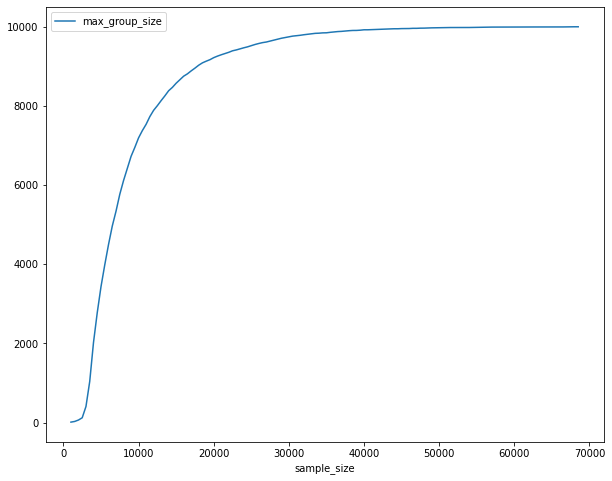

In [42]:
max_group_size_per_sample.plot(x='sample_size', y='max_group_size', figsize=(10,8))
plt.show()